## Import Basic Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings as warn

from numpy import arange
%matplotlib inline
warn.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

CONSTANT_SEED = 100

## Import Main Data

In [2]:
main_heart_df = pd.read_csv('heart.csv')
main_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
# delete a single row by index value 449 - As shown in EDA
main_heart_df = main_heart_df.drop(labels=449, axis=0).reset_index(drop=True)
IPzero_heart_df = main_heart_df.copy()

## One Hot Encoding

The purpose of one hot encoding is to convert categorical data into a numerical format that machine learning algorithms can use to make predictions.

In [4]:
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
IPzero_heart_df_cat = IPzero_heart_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
ohe.fit(IPzero_heart_df_cat)
IPzero_heart_df_cat_ohe = pd.DataFrame(ohe.transform(IPzero_heart_df_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(IPzero_heart_df_cat.columns))

# Check the encoded variables
IPzero_heart_df_cat_ohe.info()

print('')

# Combining Numeric features with the OHE Categorical features
IPzero_heart_df_num = IPzero_heart_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
IPzero_heart_df_res = IPzero_heart_df['HeartDisease']
IPzero_heart_df_ohe = pd.concat([IPzero_heart_df_num, IPzero_heart_df_cat_ohe, IPzero_heart_df_res], 
                           sort = False, axis = 1).reindex(index=IPzero_heart_df_num.index)

# Check the final dataframe
IPzero_heart_df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              917 non-null    float64
 1   Sex_M              917 non-null    float64
 2   ChestPainType_ASY  917 non-null    float64
 3   ChestPainType_ATA  917 non-null    float64
 4   ChestPainType_NAP  917 non-null    float64
 5   ChestPainType_TA   917 non-null    float64
 6   FastingBS_0        917 non-null    float64
 7   FastingBS_1        917 non-null    float64
 8   RestingECG_LVH     917 non-null    float64
 9   RestingECG_Normal  917 non-null    float64
 10  RestingECG_ST      917 non-null    float64
 11  ExerciseAngina_N   917 non-null    float64
 12  ExerciseAngina_Y   917 non-null    float64
 13  ST_Slope_Down      917 non-null    float64
 14  ST_Slope_Flat      917 non-null    float64
 15  ST_Slope_Up        917 non-null    float64
dtypes: float64(16)
memory usag

## Use Zero Imputation DataFrame with Outliers

In [5]:
IPzero_heart_df = IPzero_heart_df_ohe.copy()

## Split data set and implement feature scaling

In [6]:
X = IPzero_heart_df.drop(['HeartDisease'], axis=1)
y = IPzero_heart_df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)

## Feature scaling

The purpose of feature scaling is to standardize the range and/or distribution of the numerical features in a dataset. This would improve the performance of our models <br><br>
By scaling the features, we can ensure that the models are not biased towards any particular feature, and that all features contribute equally to the prediction. This would lead to improved accuracy and robustness of the machine learning model.

In [7]:
col = X_train.columns

# Select the numerical features to scale
num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Fit and transform the StandardScaler on the training set for numerical features
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])

# Transform the testing set using the fitted scaler for numerical features
X_test[num_features] = scaler.transform(X_test[num_features])

X_train = pd.DataFrame(X_train, columns=col)
X_test = pd.DataFrame(X_test, columns=col)

### X_train data set after one-hot and scaling 

In [8]:
X_train

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
418,0.692868,-0.009501,0.177204,0.133457,0.547942,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
174,-0.150423,0.436231,0.614545,-0.098628,1.013451,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
576,1.430747,0.770530,1.553006,-1.026968,0.920349,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
588,2.168627,0.436231,0.350318,-1.645862,-0.848586,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
417,-0.993714,-0.120935,0.095202,-0.369394,-0.848586,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,-1.520771,0.436231,1.115665,1.758052,-0.848586,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
871,0.165811,-0.009501,1.407225,-0.175990,0.268636,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
835,1.219925,0.157648,0.505209,-0.369394,1.758266,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
792,1.430747,-0.399517,0.505209,1.023116,-0.662382,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


### X_test data set after one-hot and scaling 

In [9]:
X_test

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
428,0.903690,-1.235265,-1.809054,-0.640160,-0.383077,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
424,0.692868,-0.678100,-1.809054,0.172138,1.013451,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
764,-1.309948,-1.123832,0.468764,1.642009,-0.848586,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
173,-0.466657,0.436231,-0.105246,1.371244,-0.848586,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
391,1.746981,-0.956682,-1.809054,-1.723223,-0.848586,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.798279,-0.120935,-1.809054,-0.833564,-0.848586,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10,-1.731594,-0.120935,0.113425,0.210818,-0.848586,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
625,-0.045012,0.547664,0.250094,-0.988287,-0.848586,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
739,0.060399,1.550561,0.022312,1.023116,-0.848586,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


# Creating function to run SVM Models

In [10]:
def svmModel(k, g, c, X_train, X_test, y_train, y_test):
    svc=SVC(kernel = k, gamma = g, C = c) 
    svc.fit(X_train.values,y_train.values)
    
    pred_train=svc.predict(X_train.values)
    pred_test=svc.predict(X_test.values)
    
    cm_train = confusion_matrix(y_train, pred_train)
    cm_test = confusion_matrix(y_test, pred_test)
    
    f, ax = plt.subplots(1,2, figsize=(13,5))
    sb.heatmap(cm_train, annot=True, fmt=".0f", annot_kws={"size": 18}, ax=ax[0])
    sb.heatmap(cm_test, annot=True, fmt=".0f", annot_kws={"size": 18}, ax=ax[1])
    
    ax[0].set_title("Train Data")
    ax[1].set_title("Test Data")
    
    TNt = cm_train[0][0]
    FPt = cm_train[0][1]
    FNt = cm_train[1][0]
    TPt = cm_train[1][1]
    
    TN = cm_test[0][0]
    FP = cm_test[0][1]
    FN = cm_test[1][0]
    TP = cm_test[1][1]
    
     # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model (Train Dataset)")
    print()
    print(classification_report(y_train, pred_train))
    print()
    
    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model (Test Dataset)")
    print()
    print(classification_report(y_test, pred_test))
    print()


# Run GridSearchCV to find the Best Model

In [11]:
svc = SVC()

parameters = [ {'C':arange(0.1, 1.2, 0.1), 'kernel':['linear'], 'gamma':['scale']},
               {'C':arange(0.1, 1.2, 0.1), 'kernel':['rbf'], 'gamma':['scale']},
               {'C':arange(0.1, 1.2, 0.1), 'kernel':['poly'] , 'gamma':['scale']},
               {'C':arange(0.1, 1.2, 0.1), 'kernel':['sigmoid'] ,'gamma':['scale']}
              ]

grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
                          'gamma': ['scale'], 'kernel': ['linear']},
                         {'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
                          'gamma': ['scale'], 'kernel': ['rbf']},
                         {'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
                          'gamma': ['scale'], 'kernel': ['poly']},
                         {'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
                          'gamma': ['scale'], 'kernel': ['sigmoid']}],
             scoring='f1')

In [12]:
# examine the best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

GridSearch CV best score : 0.8800


Parameters that give the best results : 

 {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}


### Model 1: IPzero_heart_df (No imputation / With outliers)

Goodness of Fit of Model (Train Dataset)

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       333
           1       0.88      0.92      0.90       400

    accuracy                           0.89       733
   macro avg       0.89      0.89      0.89       733
weighted avg       0.89      0.89      0.89       733


Goodness of Fit of Model (Test Dataset)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88        77
           1       0.92      0.91      0.91       107

    accuracy                           0.90       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.90      0.90      0.90       184




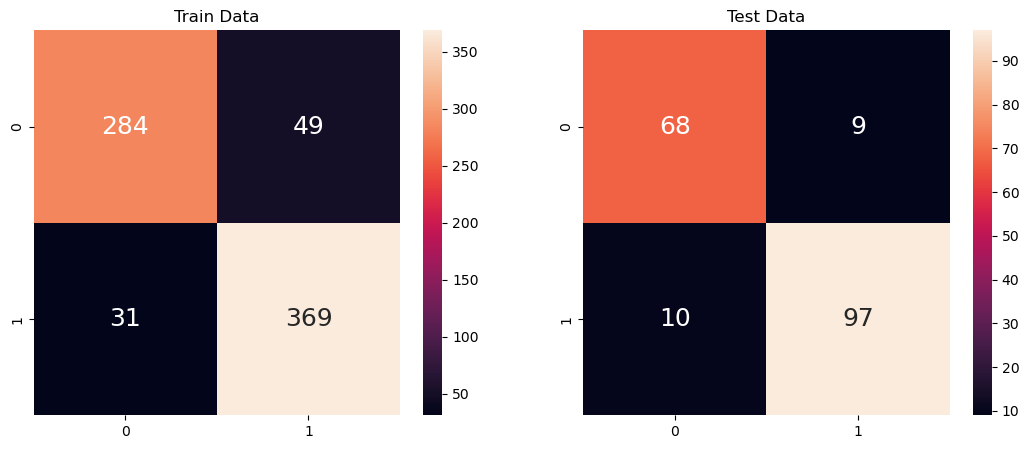

In [13]:
svmModel(grid_search.best_params_['kernel'], grid_search.best_params_['gamma'], 
             grid_search.best_params_['C'], X_train, X_test, y_train, y_test)

### Create a function to repeat the steps above for every model

We would have to implement One Hot Encoding and Feature Scaling for all of our models. Hence it would be a good idea to create a function to do this for us.

In [14]:
def process(name_df):
    #One hot implementation
    ohe = OneHotEncoder()

    # OneHotEncoding of categorical predictors (not the response)
    name_df_cat = name_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
    ohe.fit(name_df_cat)
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df_cat).toarray(), 
                                      columns=ohe.get_feature_names_out(name_df_cat.columns))

    # Check the encoded variables
    name_df_cat_ohe.info()

    print('')

    # Combining Numeric features with the OHE Categorical features
    name_df_num = name_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
    name_df_res = name_df['HeartDisease']
    name_df_ohe = pd.concat([name_df_num, name_df_cat_ohe , name_df_res], 
                               sort = False, axis = 1).reindex(index=name_df_num.index)

    # Check the final dataframe
    # IPzero_heart_df_ohe.info()
    
    # Split the data and implement feature scaling
    X = name_df_ohe.drop(['HeartDisease'], axis=1)
    y = name_df_ohe['HeartDisease']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)
    
    col = X_train.columns

    # Select the numerical features to scale
    num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

    # Fit and transform the StandardScaler on the training set for numerical features
    scaler = StandardScaler()
    X_train[num_features] = scaler.fit_transform(X_train[num_features])

    # Transform the testing set using the fitted scaler for numerical features
    X_test[num_features] = scaler.transform(X_test[num_features])

    X_train = pd.DataFrame(X_train, columns=col)
    X_test = pd.DataFrame(X_test, columns=col)

    #GridSearchCV
    svc = SVC()

    parameters = [ {'C':arange(0.1, 1.2, 0.1), 'kernel':['linear'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['rbf'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['poly'] , 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['sigmoid'] ,'gamma':['scale']}
                ]

    grid_search = GridSearchCV(estimator = svc,  
                               param_grid = parameters,
                               scoring = 'f1',
                               cv = 5,
                               verbose=0)


    grid_search.fit(X_train.values, y_train.values)
    
    # examine the best model


    # best score achieved during the GridSearchCV
    print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


    # print parameters that give the best results
    print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
    
    
    
    # Use best parameters in svmModel function
    svmModel(grid_search.best_params_['kernel'], grid_search.best_params_['gamma'], 
             grid_search.best_params_['C'], X_train, X_test, y_train, y_test)
    
    return 

# Imputation

Imputation is a technique used to fill in missing values in a dataset. The purpose of imputation is to make use of as much of the available data as possible, which can improve the accuracy and reliability of machine learning models. <br><br>

Imputation helps to fill in the missing values with estimates based on the available data. The choice of imputation method depends on the nature of the missing data and the statistical properties of the dataset.  <br><br>

There are various methods of imputation, ranging from simple methods such as mean imputation, to more complex methods such as regression imputation or K-nearest neighbors imputation. For this exploration we will focus on mean and median imputation.  <br><br>

By filling in missing values with imputed values, we can reduce the bias and variability of our estimates, and improve the performance of machine learning models. However, it is important to note that imputation introduces some uncertainty into the dataset, and the choice of imputation method can affect the accuracy and reliability of the results  <br><br>

### Create a function to impute values

In [15]:
def imputer(name_df, method):

    # create SimpleImputer object
    imputer = SimpleImputer(missing_values=0, strategy=method)

    # fit imputer to 'cholesterol' column
    imputer.fit(name_df[['Cholesterol']])

    # transform 'cholesterol' column by replacing 0 with mean value
    name_df['Cholesterol'] = imputer.transform(name_df[['Cholesterol']])
    
    return name_df

### Model 2: IPmean_heart_df (Mean imputation / With outliers)

In [16]:
#Impute mean for every '0' value in Choelestrol
IPmean_heart_df = main_heart_df.copy()
IPmean_heart_df = imputer(IPmean_heart_df, 'mean')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              917 non-null    float64
 1   Sex_M              917 non-null    float64
 2   ChestPainType_ASY  917 non-null    float64
 3   ChestPainType_ATA  917 non-null    float64
 4   ChestPainType_NAP  917 non-null    float64
 5   ChestPainType_TA   917 non-null    float64
 6   FastingBS_0        917 non-null    float64
 7   FastingBS_1        917 non-null    float64
 8   RestingECG_LVH     917 non-null    float64
 9   RestingECG_Normal  917 non-null    float64
 10  RestingECG_ST      917 non-null    float64
 11  ExerciseAngina_N   917 non-null    float64
 12  ExerciseAngina_Y   917 non-null    float64
 13  ST_Slope_Down      917 non-null    float64
 14  ST_Slope_Flat      917 non-null    float64
 15  ST_Slope_Up        917 non-null    float64
dtypes: float64(16)
memory usag

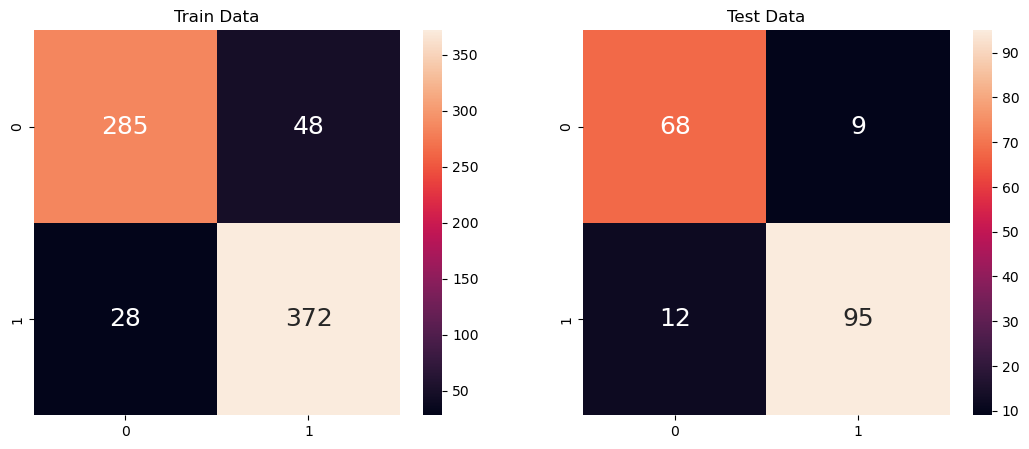

In [17]:
process(IPmean_heart_df)

### Model 3: IPmedian_heart_df (Median imputation / With outliers)

In [18]:
#Impute median for every '0' value in Choelestrol
IPmedian_heart_df = main_heart_df.copy()
IPmedian_heart_df = imputer(IPmedian_heart_df, 'median')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              917 non-null    float64
 1   Sex_M              917 non-null    float64
 2   ChestPainType_ASY  917 non-null    float64
 3   ChestPainType_ATA  917 non-null    float64
 4   ChestPainType_NAP  917 non-null    float64
 5   ChestPainType_TA   917 non-null    float64
 6   FastingBS_0        917 non-null    float64
 7   FastingBS_1        917 non-null    float64
 8   RestingECG_LVH     917 non-null    float64
 9   RestingECG_Normal  917 non-null    float64
 10  RestingECG_ST      917 non-null    float64
 11  ExerciseAngina_N   917 non-null    float64
 12  ExerciseAngina_Y   917 non-null    float64
 13  ST_Slope_Down      917 non-null    float64
 14  ST_Slope_Flat      917 non-null    float64
 15  ST_Slope_Up        917 non-null    float64
dtypes: float64(16)
memory usag

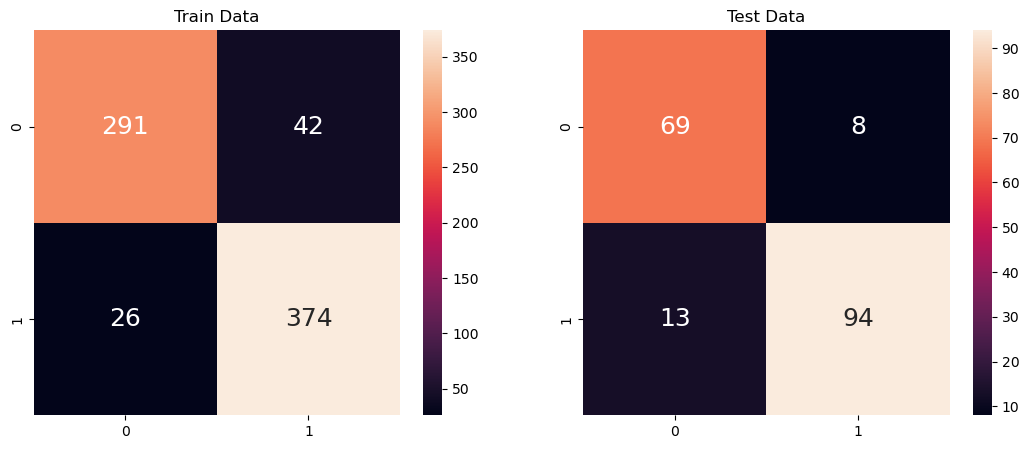

In [19]:
process(IPmedian_heart_df)

## Handle Outliers

### Create a function to remove outliers

In [20]:
# define a function called "Outliers" which returns a list of outliers 
# IQR = Q3-Q1
# +/- 1.5* IQR

def remove_outliers(name_df):
    num_cols = name_df.select_dtypes(include=[np.number]).columns
    cat_cols = name_df.select_dtypes(exclude=[np.number]).columns
    
    Q1 = name_df[num_cols].quantile(0.25)
    Q3 = name_df[num_cols].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = ((name_df[num_cols] < lower_bound) | (name_df[num_cols] > upper_bound)).any(axis=1)
    
    return name_df.loc[~outlier_mask, :]

### Model 4: IPzero_N0_outliers_heart_df (No imputation / Without outliers)

In [21]:
# Deleting Outliers and creating new Dataframe IPzero_N0_outliers_heart_df
IPzero_N0_outliers_heart_df = main_heart_df.copy()
IPzero_N0_outliers_heart_df = remove_outliers(IPzero_N0_outliers_heart_df).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              588 non-null    float64
 1   Sex_M              588 non-null    float64
 2   ChestPainType_ASY  588 non-null    float64
 3   ChestPainType_ATA  588 non-null    float64
 4   ChestPainType_NAP  588 non-null    float64
 5   ChestPainType_TA   588 non-null    float64
 6   FastingBS_0        588 non-null    float64
 7   RestingECG_LVH     588 non-null    float64
 8   RestingECG_Normal  588 non-null    float64
 9   RestingECG_ST      588 non-null    float64
 10  ExerciseAngina_N   588 non-null    float64
 11  ExerciseAngina_Y   588 non-null    float64
 12  ST_Slope_Down      588 non-null    float64
 13  ST_Slope_Flat      588 non-null    float64
 14  ST_Slope_Up        588 non-null    float64
dtypes: float64(15)
memory usage: 69.0 KB

GridSearch CV best score : 0.8405




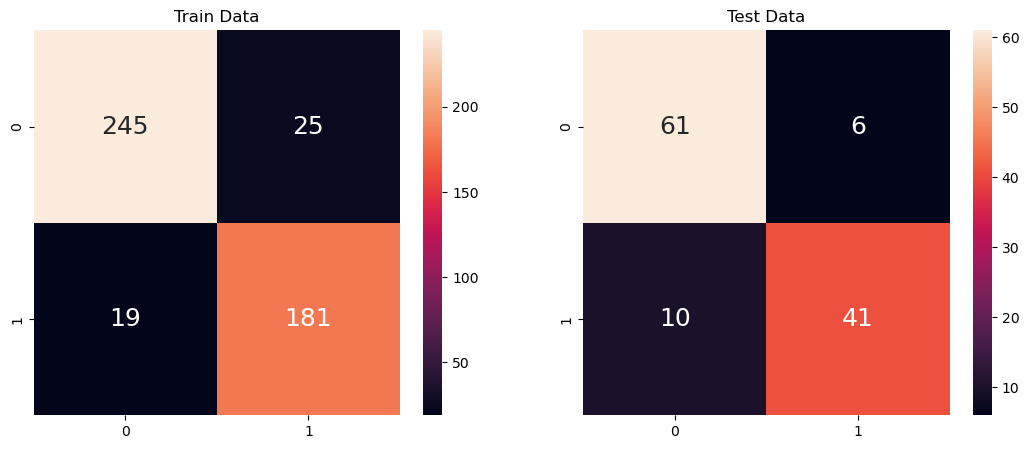

In [22]:
process(IPzero_N0_outliers_heart_df)

### Model 5: IPmean_N0_outliers_heart_df (Mean imputation / Without outliers)

In [23]:
# Deleting Outliers and creating new Dataframe IPmean_N0_outliers_heart_df
IPmean_N0_outliers_heart_df = main_heart_df.copy()

#Impute mean for every '0' value in Choelestrol
IPmean_N0_outliers_heart_df = imputer(IPmean_N0_outliers_heart_df, 'mean')

IPmean_N0_outliers_heart_df = remove_outliers(IPmean_N0_outliers_heart_df).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              642 non-null    float64
 1   Sex_M              642 non-null    float64
 2   ChestPainType_ASY  642 non-null    float64
 3   ChestPainType_ATA  642 non-null    float64
 4   ChestPainType_NAP  642 non-null    float64
 5   ChestPainType_TA   642 non-null    float64
 6   FastingBS_0        642 non-null    float64
 7   RestingECG_LVH     642 non-null    float64
 8   RestingECG_Normal  642 non-null    float64
 9   RestingECG_ST      642 non-null    float64
 10  ExerciseAngina_N   642 non-null    float64
 11  ExerciseAngina_Y   642 non-null    float64
 12  ST_Slope_Down      642 non-null    float64
 13  ST_Slope_Flat      642 non-null    float64
 14  ST_Slope_Up        642 non-null    float64
dtypes: float64(15)
memory usage: 75.4 KB

GridSearch CV best score : 0.8503




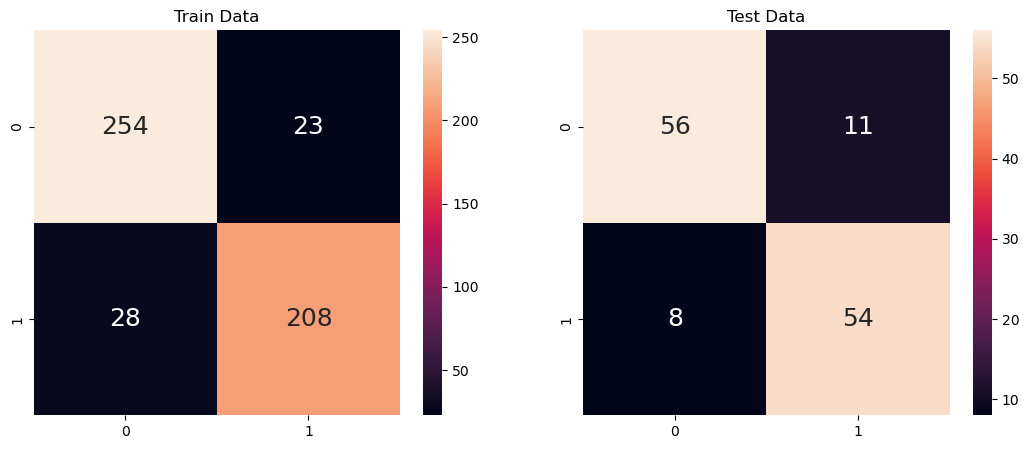

In [24]:
process(IPmean_N0_outliers_heart_df)

### Model 6: IPmedian_N0_outliers_heart_df (Median imputation / Without outliers)

In [25]:
# Deleting Outliers and creating new Dataframe IPmedian_N0_outliers_heart_df
IPmedian_N0_outliers_heart_df = main_heart_df.copy()

#Impute median for every '0' value in Choelestrol
IPmedian_N0_outliers_heart_df = imputer(IPmedian_N0_outliers_heart_df, 'median')

IPmedian_N0_outliers_heart_df = remove_outliers(IPmedian_N0_outliers_heart_df).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              642 non-null    float64
 1   Sex_M              642 non-null    float64
 2   ChestPainType_ASY  642 non-null    float64
 3   ChestPainType_ATA  642 non-null    float64
 4   ChestPainType_NAP  642 non-null    float64
 5   ChestPainType_TA   642 non-null    float64
 6   FastingBS_0        642 non-null    float64
 7   RestingECG_LVH     642 non-null    float64
 8   RestingECG_Normal  642 non-null    float64
 9   RestingECG_ST      642 non-null    float64
 10  ExerciseAngina_N   642 non-null    float64
 11  ExerciseAngina_Y   642 non-null    float64
 12  ST_Slope_Down      642 non-null    float64
 13  ST_Slope_Flat      642 non-null    float64
 14  ST_Slope_Up        642 non-null    float64
dtypes: float64(15)
memory usage: 75.4 KB

GridSearch CV best score : 0.8513




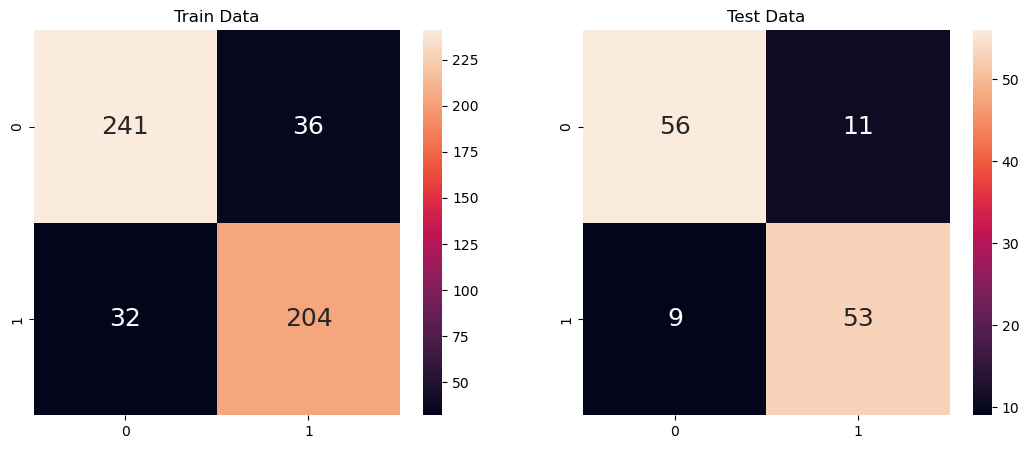

In [26]:
process(IPmedian_N0_outliers_heart_df)

## Null Accuracy Check


Null accuracy refers to the accuracy that could be achieved by always predicting the most frequent class in a dataset, regardless of the input features. The purpose of null accuracy check is to determine the baseline accuracy level that a machine learning model should aim to surpass.<br><br>

In [27]:
y_test.value_counts()

1    107
0     77
Name: HeartDisease, dtype: int64

In [28]:
null_accuracy = (105/(105+79))

print('Null accuracy score: {0:0.4f}'. format((null_accuracy)*100))

Null accuracy score: 57.0652


All of our models pass the null accuracy check

# Classification Report Across All Models

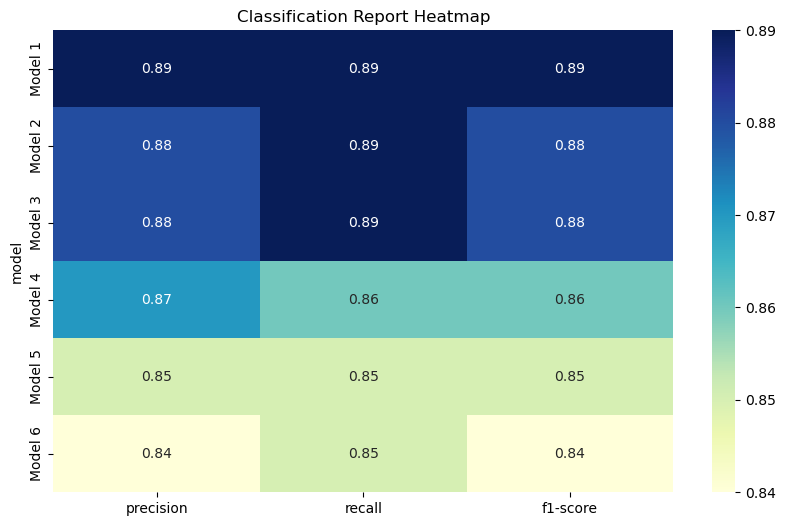

In [29]:
# create a list of all the classification reports

reports = [
    {'model': 'Model 1', 'precision': 0.89, 'recall': 0.89, 'f1-score': 0.89},
    {'model': 'Model 2', 'precision': 0.88, 'recall': 0.89, 'f1-score': 0.88},
    {'model': 'Model 3', 'precision': 0.88, 'recall': 0.89, 'f1-score': 0.88},
    {'model': 'Model 4', 'precision': 0.87, 'recall': 0.86, 'f1-score': 0.86},
    {'model': 'Model 5', 'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85},
    {'model': 'Model 6', 'precision': 0.84, 'recall': 0.85, 'f1-score': 0.84}
]

# create a dataframe from the classification reports
df = pd.DataFrame(reports)

# set the model column as the index
df.set_index('model', inplace=True)

# create a heatmap using seaborn
plt.figure(figsize=(10,6))
sb.heatmap(df, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

MODEL 1 : Zero Imputation 

MODEL 2 : Mean Imputation 

MODEL 3 : Median Imputation 

MODEL 4 : Zero Imputation without Outliers

MODEL 5 : Mean Imputation without Outliers

MODEL 6 : Median Imputation without Outliers

We can observe that imputation does not lead to a large change in precision , recall or f1-score. This is because mean imputation of value (244.6) or median imputation of value (237) are not too far apart in magnitude. More importantly, the Cholestrol variable has a rather low correlation with Heart Diesease. Hence, changes made to that variable may not significantly impact the f1-score of the models

We choose the two models with the highest value across the three metrics (Models 2 and 3) for further analysis. 


We chose to ignore Models 1 as we know that SVM models can be sensitive to outliers, especially if the outliers are extreme and have a significant impact on the margin of the classifier. In this case, the zero imputation of missing values values of 'Cholesterol' is a extreme outliers as shown in the EDA.

We also chose to ignore model 4 despite their high recall and f1-score as they might be overfit to the training data, as previously mentioned under observation for models without outliers

# Further Analysis to Find the Best Model

We further analyse Models 2 and 3 to find out which of them is truly the best to identify Heart Disease. <br><br>

We can use a two pronged approach to find the effectiveness of the models <br><br>

1. Learning Curves<br><br>
A learning curve is a tool used in machine learning to help evaluate the performance of a model. It is a graphical representation of how the model's accuracy, error or other performance metric changes as the size of the training dataset is increased. <br><br>
The purpose of a learning curve is to provide insight into how well the model is learning from the data, and whether the model is overfitting or underfitting.<br><br>

2. ROC AUC (Receiver Operating Characteristic - Area Under the Curve)<br><br>
ROC AUC (Receiver Operating Characteristic - Area Under the Curve) is a performance metric used to evaluate the performance of a classification model. It is a graphical representation of the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) across different classification thresholds.

### Create a function to implement Learning Curves and ROC_AUC

In [30]:
def compare(name_df):
    
    #One hot implementation
    ohe = OneHotEncoder()

    # OneHotEncoding of categorical predictors (not the response)
    name_df_cat = name_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
    ohe.fit(name_df_cat)
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df_cat).toarray(), 
                                      columns=ohe.get_feature_names_out(name_df_cat.columns))

    # Check the encoded variables
    name_df_cat_ohe.info()

    print('')

    # Combining Numeric features with the OHE Categorical features
    name_df_num = name_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
    name_df_res = name_df['HeartDisease']
    name_df_ohe = pd.concat([name_df_num, name_df_cat_ohe , name_df_res], 
                               sort = False, axis = 1).reindex(index=name_df_num.index)
    # Extract Response and Predictors
    y = pd.DataFrame(name_df_ohe['HeartDisease'])
    X = pd.DataFrame(name_df_ohe.drop('HeartDisease', axis = 1))
    
    # Split data into training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONSTANT_SEED)
    
    col = X_train.columns

    # Select the numerical features to scale
    num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

    # Fit and transform the StandardScaler on the training set for numerical features
    scaler = StandardScaler()
    X_train[num_features] = scaler.fit_transform(X_train[num_features])

    # Transform the testing set using the fitted scaler for numerical features
    X_test[num_features] = scaler.transform(X_test[num_features])

    X_train = pd.DataFrame(X_train, columns=col)
    X_test = pd.DataFrame(X_test, columns=col)

    #GridSearchCV
    svc = SVC()

    parameters = [ {'C':arange(0.1, 1.2, 0.1), 'kernel':['linear'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['rbf'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['poly'] , 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['sigmoid'] ,'gamma':['scale']}
                ]

    grid_search = GridSearchCV(estimator = svc,  
                               param_grid = parameters,
                               scoring = 'f1',
                               cv = 5,
                               verbose=0)


    grid_search.fit(X_train.values, y_train.values)
    
    
    # Initialize a SVC object
    svc=SVC(kernel = grid_search.best_params_['kernel'],
            gamma = grid_search.best_params_['gamma'], 
            C =  grid_search.best_params_['C']) 
    svc.fit(X_train,y_train)
    
    
    # Set up the learning curve parameters
    train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9] # training set sizes to use
    cv = 5 # number of cross-validation folds
    scoring = 'accuracy' # metric to evaluate the model on

    # Calculate the learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator=svc,
                                                            X=X_train, y=y_train.values.ravel(),
                                                            train_sizes=train_sizes,
                                                            cv=cv,
                                                            scoring=scoring)
    
    plt.figure()
    plt.title('Learning curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')

    # Calculate mean and standard deviation of the training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the mean training and test scores with bands indicating the uncertainty
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")

    plt.show()
    
    # Get decision scores for the test set
    y_score = svc.decision_function(X_test)

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_score)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print("ROC-AUC Score:", roc_auc)
    
    return name_df_ohe

### Model 2: IPmean_heart_df (Mean imputation / With outliers)

In [31]:
# Deleting Outliers and creating new Dataframe IPmean_N0_outliers_heart_df
IPmean_heart_df = main_heart_df.copy()
IPmean_heart_df = imputer(IPmean_heart_df, 'mean')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              917 non-null    float64
 1   Sex_M              917 non-null    float64
 2   ChestPainType_ASY  917 non-null    float64
 3   ChestPainType_ATA  917 non-null    float64
 4   ChestPainType_NAP  917 non-null    float64
 5   ChestPainType_TA   917 non-null    float64
 6   FastingBS_0        917 non-null    float64
 7   FastingBS_1        917 non-null    float64
 8   RestingECG_LVH     917 non-null    float64
 9   RestingECG_Normal  917 non-null    float64
 10  RestingECG_ST      917 non-null    float64
 11  ExerciseAngina_N   917 non-null    float64
 12  ExerciseAngina_Y   917 non-null    float64
 13  ST_Slope_Down      917 non-null    float64
 14  ST_Slope_Flat      917 non-null    float64
 15  ST_Slope_Up        917 non-null    float64
dtypes: float64(16)
memory usag

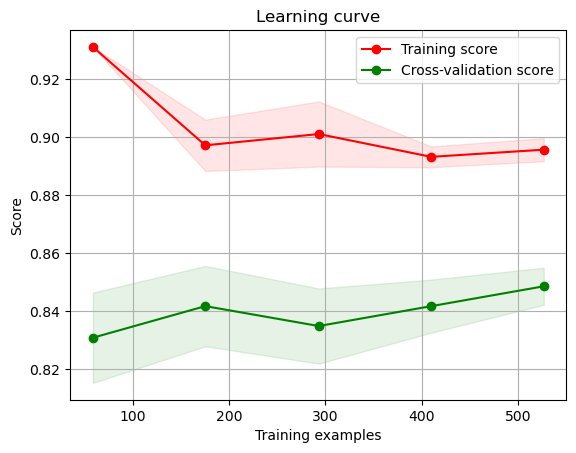

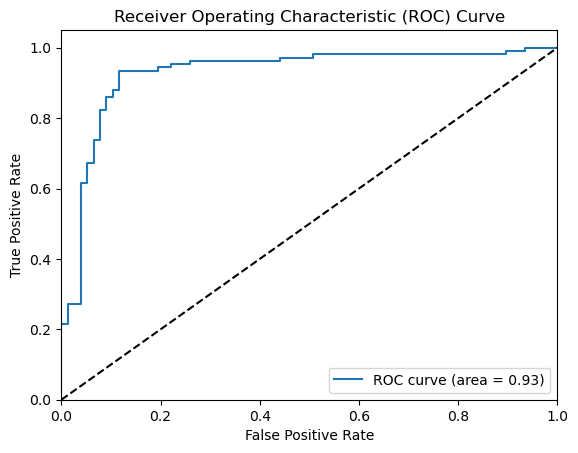

ROC-AUC Score: 0.9279038718291054


In [32]:
IPmean_heart_df = compare(IPmean_heart_df)

### Model 3: IPmedian_heart_df (Median imputation / With outliers)

In [33]:
# Deleting Outliers and creating new Dataframe IPmedian_N0_outliers_heart_df
IPmedian_heart_df = main_heart_df.copy()
IPmedian_heart_df = imputer(IPmedian_heart_df, 'median')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              917 non-null    float64
 1   Sex_M              917 non-null    float64
 2   ChestPainType_ASY  917 non-null    float64
 3   ChestPainType_ATA  917 non-null    float64
 4   ChestPainType_NAP  917 non-null    float64
 5   ChestPainType_TA   917 non-null    float64
 6   FastingBS_0        917 non-null    float64
 7   FastingBS_1        917 non-null    float64
 8   RestingECG_LVH     917 non-null    float64
 9   RestingECG_Normal  917 non-null    float64
 10  RestingECG_ST      917 non-null    float64
 11  ExerciseAngina_N   917 non-null    float64
 12  ExerciseAngina_Y   917 non-null    float64
 13  ST_Slope_Down      917 non-null    float64
 14  ST_Slope_Flat      917 non-null    float64
 15  ST_Slope_Up        917 non-null    float64
dtypes: float64(16)
memory usag

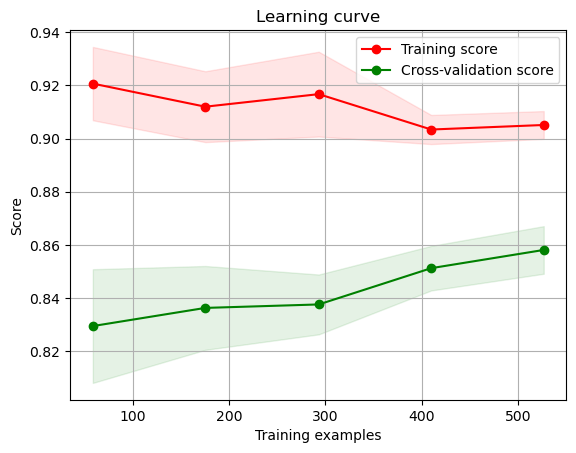

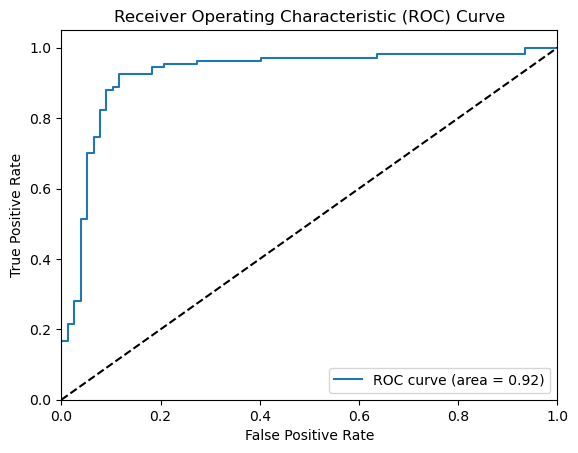

ROC-AUC Score: 0.9245054011409151


In [34]:
IPmedian_heart_df = compare(IPmedian_heart_df)

### Evaluation

Interestingly, both models return similar learning curves and ROC-AUC curves. This is, however, not surprising as both models have more or less similar datasets. The insignificance of the Cholestrol variable and the relatively small difference between mean and median imputation results in such a finding. <br><br>

Nonetheless, Model 2 returns a slightly better AOC score. Hence, this exploration conludes that Model 2 as the best SVM models to predict Heart Disease

## Feature pruning the best model


we will simply do feature prunning to find the best features in Model 2 that determines if a patient has a 'HeartDisease'. 

In [35]:
IPmean_heart_df

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289.0,172,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,49,160,180.0,156,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,37,130,283.0,98,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0
3,48,138,214.0,108,1.5,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1
4,54,150,195.0,122,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,110,264.0,132,1.2,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
913,68,144,193.0,141,3.4,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
914,57,130,131.0,115,1.2,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1
915,57,130,236.0,174,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1


### Defining a Function for Feature pruning

In [36]:
def feature_pruning(name_df):
    
    # Extract Response and Predictors
    y = pd.DataFrame(name_df['HeartDisease'])
    X = pd.DataFrame(name_df.drop('HeartDisease', axis = 1))
    
    # Split data into training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CONSTANT_SEED)
    
    col = X_train.columns

    # Select the numerical features to scale
    num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

    # Fit and transform the StandardScaler on the training set for numerical features
    scaler = StandardScaler()
    X_train[num_features] = scaler.fit_transform(X_train[num_features])

    # Transform the testing set using the fitted scaler for numerical features
    X_test[num_features] = scaler.transform(X_test[num_features])

    X_train = pd.DataFrame(X_train, columns=col)
    X_test = pd.DataFrame(X_test, columns=col)

    #GridSearchCV
    svc = SVC()

    parameters = [ {'C':arange(0.1, 1.2, 0.1), 'kernel':['linear'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['rbf'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['poly'] , 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['sigmoid'] ,'gamma':['scale']}
                ]

    grid_search = GridSearchCV(estimator = svc,  
                               param_grid = parameters,
                               scoring = 'f1',
                               cv = 5,
                               verbose=0)


    grid_search.fit(X_train.values, y_train.values)
    
    
    # Initialize a SVC object
    model=SVC(kernel = grid_search.best_params_['kernel'],
            gamma = grid_search.best_params_['gamma'], 
            C =  grid_search.best_params_['C'],random_state=CONSTANT_SEED) 
    model.fit(X_train,y_train)
    
    # Create a list to store the f1 score and the number of features
    f1_scores = []
    num_features = []
    
    # Get the feature importance from the trained model using permutation importance
    perm = permutation_importance(model, X_train, y_train, random_state=CONSTANT_SEED)
    feat_imp = perm.importances_mean

    # Sort the feature importance in descending order
    feat_imp_sorted_idx = np.argsort(feat_imp)[::-1]

    # Plot all the feature importances
    fig, ax = plt.subplots()
    ax.bar(X_train.columns[feat_imp_sorted_idx], feat_imp[feat_imp_sorted_idx])
    ax.set_xticklabels(X_train.columns[feat_imp_sorted_idx], rotation=45, ha="right")
    ax.set_ylabel("Feature Importance")
    ax.set_title("All Feature Importance")
    plt.show()

    # Define the list of all features
    all_feat = list(X_train.columns)

    # Train the model with all features
    model.fit(X_train, y_train)

    # Get the initial F1 score and print the selected features
    y_test_pred = model.predict(X_test)
    f1_score_initial = metrics.f1_score(y_test, y_test_pred, average='macro')
    print("Initial F1 score:", f1_score_initial)
    print(' ')

    # Create lists to store the f1 score and the number of features
    f1_scores = [f1_score_initial]
    num_features = [len(all_feat)]

    # Remove the least important feature one by one until only the top 3 features are remaining
    while len(all_feat) > 3:
        # Train the model with the selected features
        X_train_selected = X_train.loc[:, all_feat]
        X_test_selected = X_test.loc[:, all_feat]
        model.fit(X_train_selected, y_train)

        # Get the feature importance from the trained model using permutation importance
        perm = permutation_importance(model, X_train_selected, y_train, random_state=CONSTANT_SEED)
        feat_imp = perm.importances_mean

        # Remove the least important feature and print the selected features
        feat_imp_sorted_idx = np.argsort(feat_imp)[::-1]
        least_imp_idx = feat_imp_sorted_idx[len(all_feat)-1]
        print('----------------------------------------------------------------------')
        print("Removing feature {} ({})".format(X_train_selected.columns[least_imp_idx], feat_imp[least_imp_idx]))
        all_feat.remove(X_train_selected.columns[least_imp_idx])

        # Print classification report and append the f1 score and number of features
        y_test_pred = model.predict(X_test_selected)
        f1_score_val = metrics.f1_score(y_test, y_test_pred, average='macro')
        f1_scores.append(f1_score_val)
        num_features.append(len(all_feat))
        print(' ')
        print("Classification report after removing feature '{}':".format(X_train_selected.columns[least_imp_idx]))
        print(classification_report(y_test, y_test_pred))
        print(' ')
        
        
    print('----------------------------------------------------------------------')
    print(' ')
    print("Final selected features:", all_feat)
    print(' ')
    print('----------------------------------------------------------------------')
    print(' ')
    


    num_features_removed = list(range(0, len(f1_scores)))

    fig, ax = plt.subplots()
    sb.lineplot(x=num_features_removed, y=f1_scores, marker='o')
    ax.set_xlabel("Number of features removed")
    ax.set_ylabel("F1 score")
    ax.set_title("F1 score vs Number of features removed")
    ax.axhline(y=f1_score_initial, linestyle='--', label='Initial F1 score', color='gray')
    ax.legend()
    plt.xticks(num_features_removed)
    plt.show()


 

### Metric of Feature Importance

**Permutation importance** is a feature importance measure that works well with non-linear models like SVM, even when the kernel is not linear. This is because permutation importance is a model-agnostic method that measures the contribution of each feature to the model's performance by evaluating the decrease in model performance when the feature's values are randomly permuted.

permutation importance provides a simple and interpretable way to understand which features are driving the model's predictions. This can be particularly valuable in applications where interpretability is important, such as in medicine

We note that **permutation importance of each feature can change as other features are removed** from the model. When features are removed, the remaining features may become more or less important in the model's predictions, and this can affect the permutation importance of each feature.

Nonetheless we believe that Permutation importance can still provide a good metric to determine the feature importance.

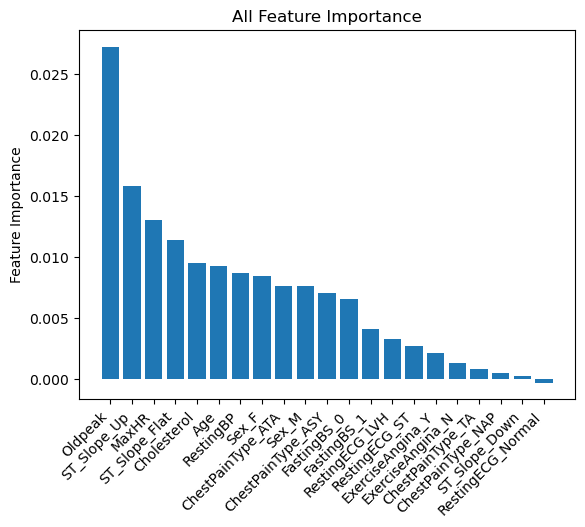

Initial F1 score: 0.8833579859329248
 
----------------------------------------------------------------------
Removing feature RestingECG_Normal (-0.0002728512960436413)
 
Classification report after removing feature 'RestingECG_Normal':
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        77
           1       0.91      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184

 
----------------------------------------------------------------------
Removing feature RestingECG_ST (4.4408920985006264e-17)
 
Classification report after removing feature 'RestingECG_ST':
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        77
           1       0.92      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.89 

----------------------------------------------------------------------
Removing feature Cholesterol (0.013642564802182844)
 
Classification report after removing feature 'Cholesterol':
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        77
           1       0.87      0.91      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.87      0.87       184

 
----------------------------------------------------------------------
Removing feature Sex_F (0.02264665757162345)
 
Classification report after removing feature 'Sex_F':
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        77
           1       0.92      0.87      0.89       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.8

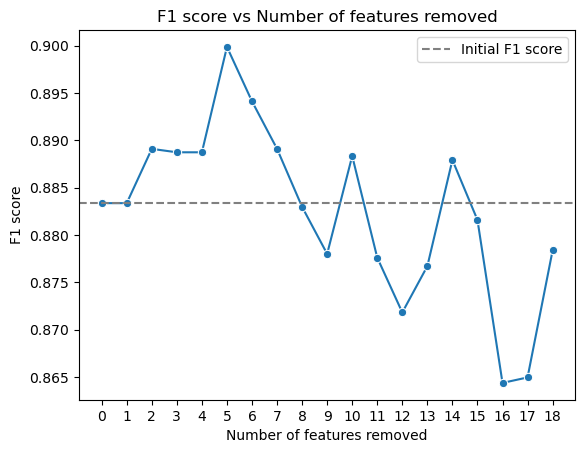

In [37]:
feature_pruning(IPmean_heart_df)

## Evaluation

From the line graph, it was hard to find a trend but it seems that the f1 score was generally depreciating. Although the were some irregularity in terms of the change of the f1 score as the features are being removed, there were 2 distinct points that showed a significant change in the f1 score that might suggest some implication.

They are namely, **'ChestPainType_ASY'** when feature 16 is removed and **'Sex_F'** when feature 18 is removed respectively. 
This might suggest that two features were important in the training process and might indicate that they are likely to affect '**HeartDisease'**

Furthermore , the last 3 remaining features that were chosen **'Oldpeak'**, **'ExerciseAngina_N'** and **'ST_Slope_Up'** suggest that theese features are crucial in determining if a patient is more likely to get 'HeartDisease' by virtue of their Permutation importance. 

## Feature Conclusion

**'ChestPainType_ASY'** , **'Sex_F'** ,**'Oldpeak'**, **'ExerciseAngina_N'** and **'ST_Slope_Up'** are the most important variables that might indicate a patient has **'HeartDisease'**

## Best model with best features

In [38]:
IPmean_heart_df

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289.0,172,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,49,160,180.0,156,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,37,130,283.0,98,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0
3,48,138,214.0,108,1.5,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1
4,54,150,195.0,122,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,110,264.0,132,1.2,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
913,68,144,193.0,141,3.4,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
914,57,130,131.0,115,1.2,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1
915,57,130,236.0,174,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1


In [39]:
def Best_model_process(name_df):
    #One hot implementation
    ohe = OneHotEncoder()

    # OneHotEncoding of categorical predictors (not the response)
    name_df_cat = name_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
    ohe.fit(name_df_cat)
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df_cat).toarray(), 
                                      columns=ohe.get_feature_names_out(name_df_cat.columns))

    # Select the binary columns to keep
    bin_cols = ['ChestPainType_ASY', 'Sex_F', 'ExerciseAngina_N',
                'ST_Slope_Up']
    bin_cols

    print('')

    # Combining Numeric features with the OHE Categorical features
    name_df_num = name_df[['Oldpeak']]
    name_df_res = name_df['HeartDisease']
    name_df_ohe = pd.concat([name_df_num, name_df_cat_ohe[bin_cols] , name_df_res], 
                               sort = False, axis = 1).reindex(index=name_df_num.index)
        
    # Check the final dataframe
    name_df_ohe.info()
    
    # Split the data and implement feature scaling
    X = name_df_ohe.drop(['HeartDisease'], axis=1)
    y = name_df_ohe['HeartDisease']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)
    
    col = X_train.columns

    # Select the numerical features to scale
    num_features = ['Oldpeak']

    # Fit and transform the StandardScaler on the training set for numerical features
    scaler = StandardScaler()
    X_train[num_features] = scaler.fit_transform(X_train[num_features])

    # Transform the testing set using the fitted scaler for numerical features
    X_test[num_features] = scaler.transform(X_test[num_features])

    X_train = pd.DataFrame(X_train, columns=col)
    X_test = pd.DataFrame(X_test, columns=col)

    #GridSearchCV
    svc = SVC()

    parameters = [ {'C':arange(0.1, 1.2, 0.1), 'kernel':['linear'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['rbf'], 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['poly'] , 'gamma':['scale']},
                   {'C':arange(0.1, 1.2, 0.1), 'kernel':['sigmoid'] ,'gamma':['scale']}
                ]

    grid_search = GridSearchCV(estimator = svc,  
                               param_grid = parameters,
                               scoring = 'f1',
                               cv = 5,
                               verbose=0)


    grid_search.fit(X_train.values, y_train.values)
    
    # examine the best model


    # best score achieved during the GridSearchCV
    print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


    # print parameters that give the best results
    print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
    
    
    
    # Use best parameters in svmModel function
    svmModel(grid_search.best_params_['kernel'], grid_search.best_params_['gamma'], 
             grid_search.best_params_['C'], X_train, X_test, y_train, y_test)
    
    return 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Oldpeak            917 non-null    float64
 1   ChestPainType_ASY  917 non-null    float64
 2   Sex_F              917 non-null    float64
 3   ExerciseAngina_N   917 non-null    float64
 4   ST_Slope_Up        917 non-null    float64
 5   HeartDisease       917 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.1 KB
GridSearch CV best score : 0.8716


Parameters that give the best results : 

 {'C': 0.4, 'gamma': 'scale', 'kernel': 'rbf'}
Goodness of Fit of Model (Train Dataset)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       333
           1       0.85      0.91      0.88       400

    accuracy                           0.86       733
   macro avg       0.86      0.86      0.86       733
weighted avg       0.

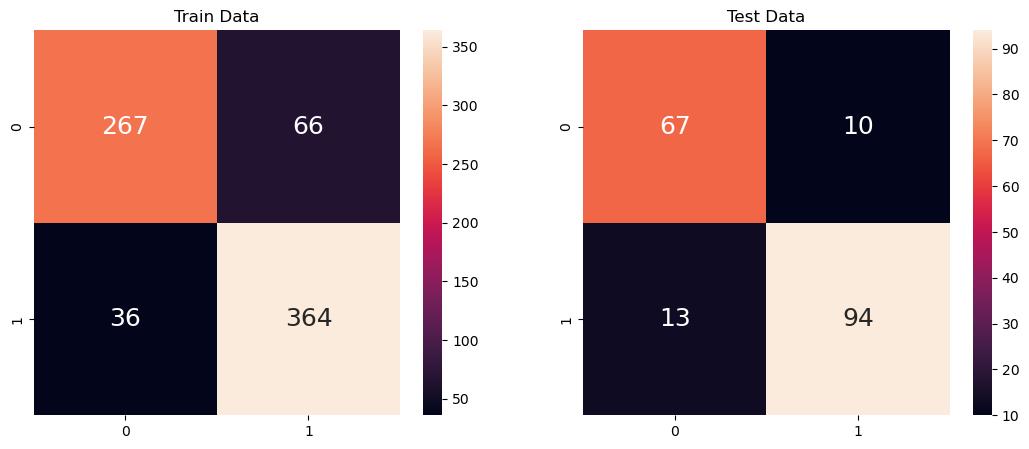

In [40]:
IPmean_heart_df = main_heart_df.copy()
IPmean_heart_df = imputer(IPmean_heart_df, 'mean')
Best_model_process(IPmean_heart_df)

## Evaluation of model before and after feature pruning 

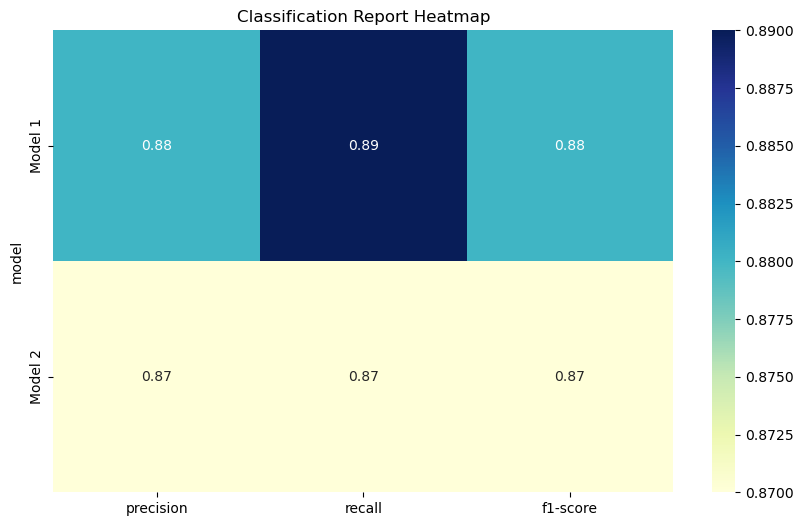

In [41]:
# create a list of all the classification reports

reports = [
    {'model': 'Model 1', 'precision': 0.88, 'recall': 0.89, 'f1-score': 0.88},
    {'model': 'Model 2', 'precision': 0.87, 'recall': 0.87, 'f1-score': 0.87},
    
]

# create a dataframe from the classification reports
df = pd.DataFrame(reports)

# set the model column as the index
df.set_index('model', inplace=True)

# create a heatmap using seaborn
plt.figure(figsize=(10,6))
sb.heatmap(df, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

MODEL 1: IPmean_heart_df Before feature pruning 

MODEL 2: IPmean_heart_df After feature pruning 

There is only a 0.1 decrease in F1 score between the 2 models. This shows that **'ChestPainType_ASY'** , **'Sex_F'** ,**'Oldpeak'**, **'ExerciseAngina_N'** and **'ST_Slope_Up'** are truly the most important features in indicating a patient has **'HeartDisease'** . 

It also suggest that SVM might be a great machine learning model to predict if a patient has **'HeartDisease'** .